# Quantum Transformer

<div style="border: 2px solid black; padding: 10px; text-align: center;">
    
</div>
    

This tutorial follows the implementation of [A Hybrid Transformer Architecture with a Quantized Self-Attention Mechanism Applied to Molecular Generation](https://arxiv.org/abs/2502.19214)

### Installation

If running locally and would like to exclusively use `pip` run the cell below:

In [1]:
%pip install cudaq==0.9.1
%pip install rdkit==2024.9.4
%pip install torch==2.5.1+cu121 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
%pip install pandas==2.2.2
%pip install torchdata==0.10.1
%pip install tqdm==4.67.1
%pip install scikit-learn==1.5.1
%pip install seaborn==0.13.2
%pip install gdown==5.2.0

If you are running on Perlmutter or would like to use `conda`, install the `cuda_quantum_transformer_env.yml` file with:

`conda env create -f cuda_quantum_transformer_env.yml`

The `yml` file already includes the `ipykernel` installation so one it does not need to be separately installed. As per the Perlmutter [instructions](https://docs.nersc.gov/services/jupyter/how-to-guides/), activate the environment and use `ipykernel install` to set up a Jupyter kernelspec.

### Algorithm and Example

#### Creating the self-attention circuits

The objective is to integrate a quantum circuit to replace the token and positional embeddings that propagate into the query and key representations, while keeping the token and positional embeddings used for the value matrix as classical. The quantum states representing the query and keys are then used to compute an attention score through their inner product, computed with a Hadamard test. The [Hadamard test](https://en.wikipedia.org/wiki/Hadamard_test) allows one to produce an expectation value of $\text{Re}\bra{\Psi}U\ket{\Psi}$ for some quantum state $\Psi$ and some unitary operator $U$. With a careful choice of $U$, one can modify the Hadamard test to produce the inner product between two quantum states of choice - to yield $\text{Re}\braket{\Psi_1 | \Psi_2}$. In this work, we learn embeddings for tokens in a sequence and take advantage of this modified-Hadamard test to compute their pairwise inner products and use these as attention scores within a transformed-based generative model. 

The figure below shows the circuit that accomplishes the learning of token/positional embeddings, learning query and key representations, and calculation of their inner product with a modified-Hadamard test. 

<div style="border: 2px solid black; padding: 10px; text-align: center;">
    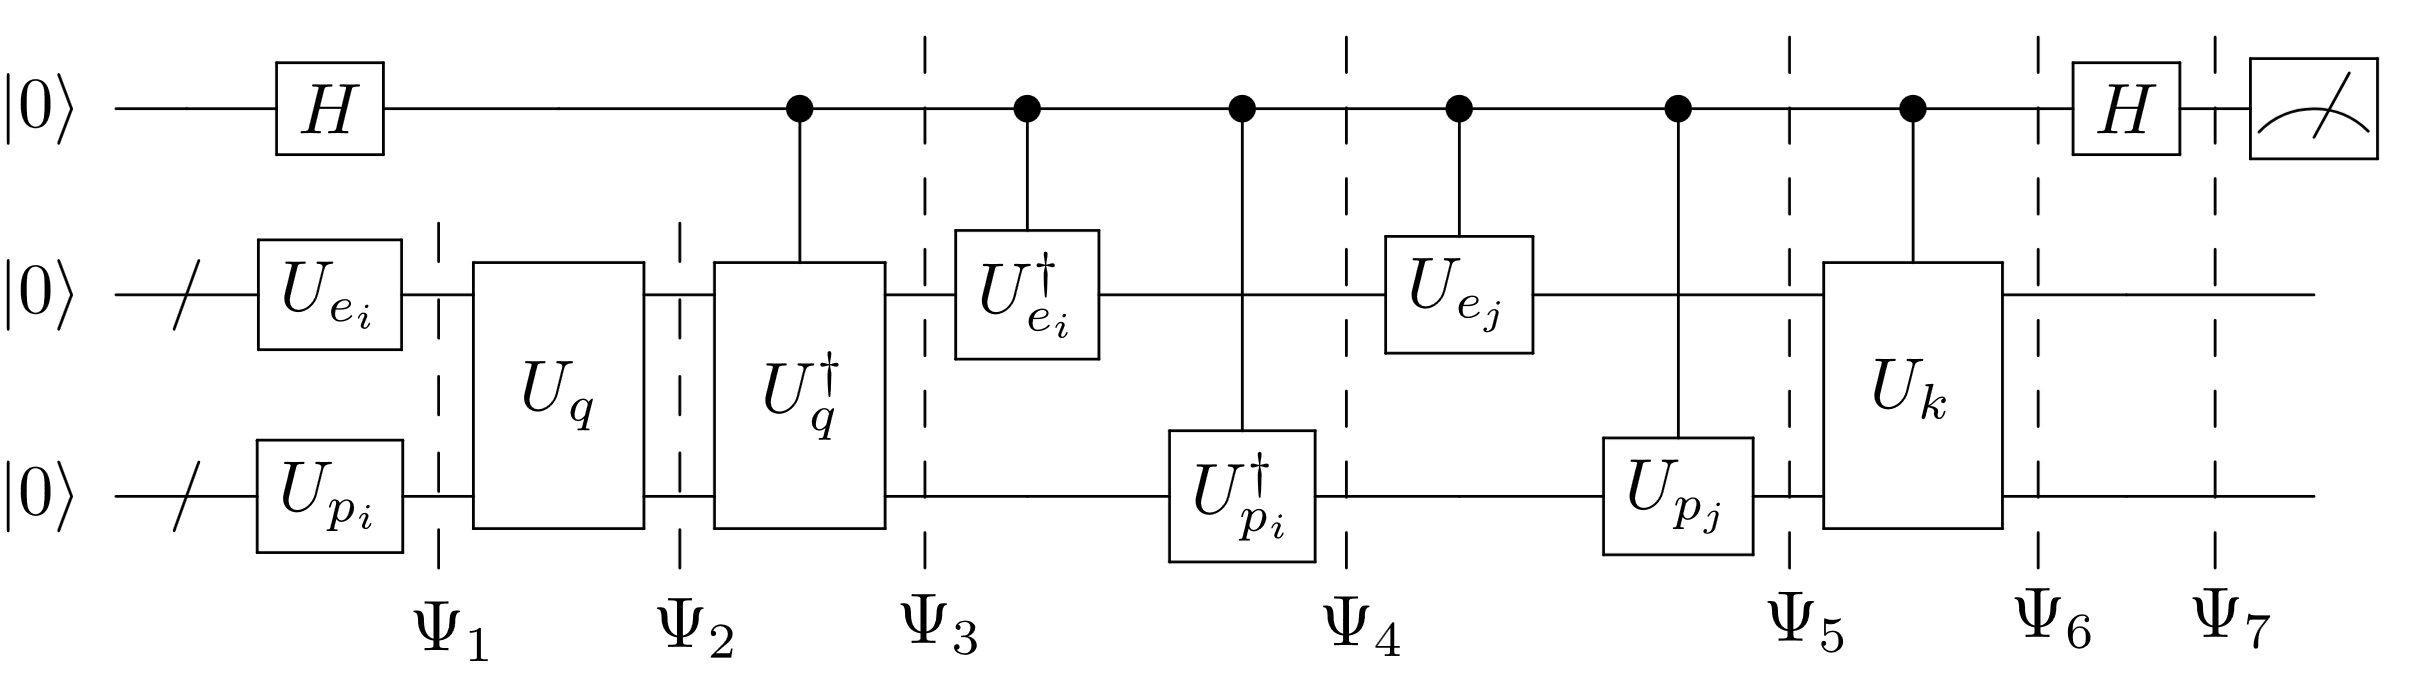
</div>

The circuit can be extended to include additional embeddings beyond token and position. In this work, we train a model with physicochemical property embeddings as well. This conditions-based quantum circuit is shown in the figure below:

<div style="border: 2px solid black; padding: 10px; text-align: center;">
    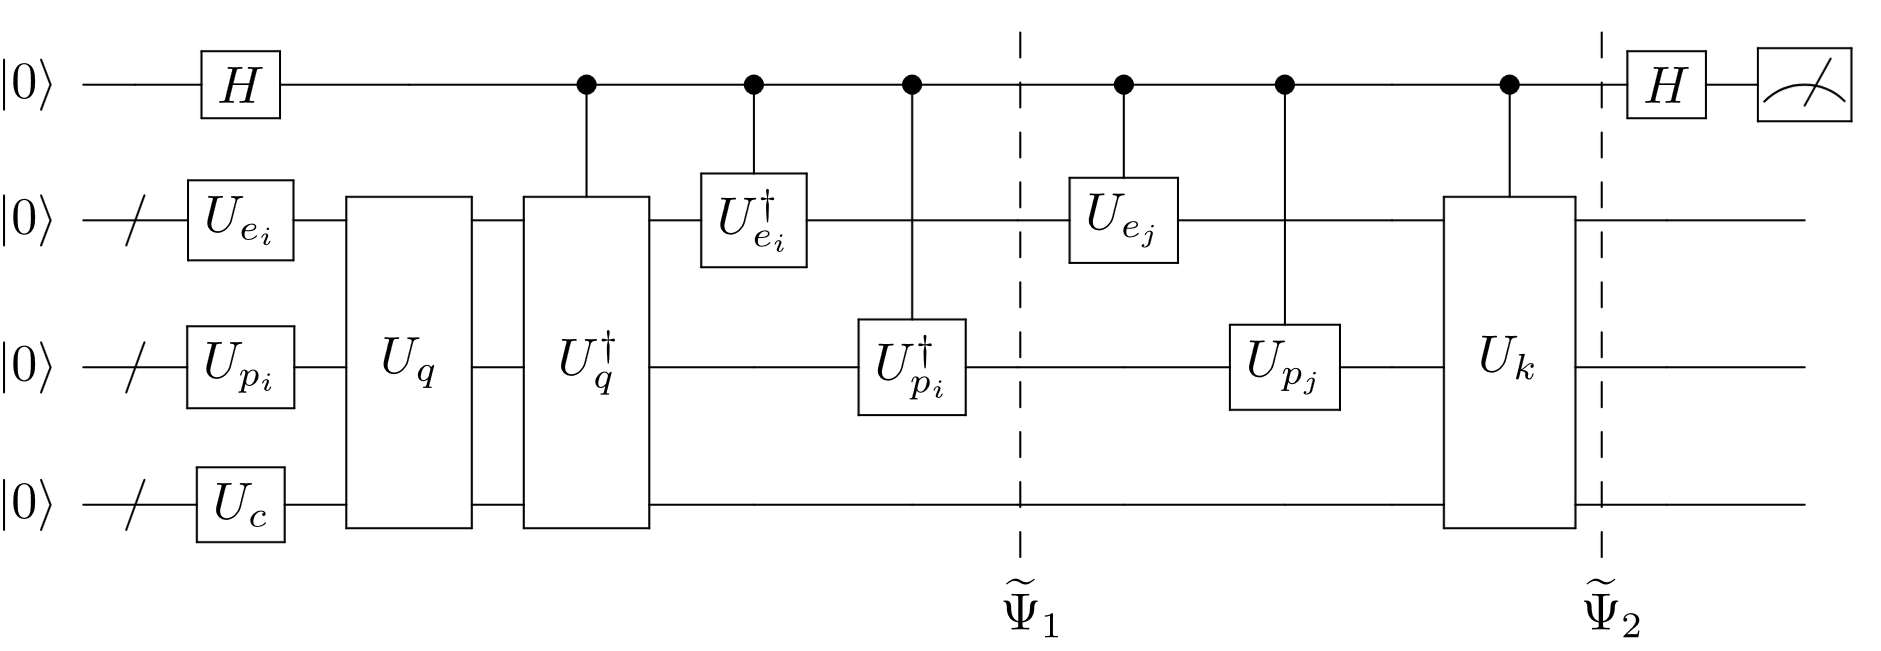
</div>

Since the quantum circuit both learns representations of embeddings as well as calculates their inner product, a number of input parameters to the circuit are required:

- Parameters to be used in the unitary $U_{e_i}$ that evolves the quantum state representing token information for token $i$ in the pair $(i,j)$
- Parameters to be used in the unitary $U_{p_i}$ to evolve the quantum state representing the positional encoding of token $i$
- Parameters to be used in the unitary $U_c$ to encode and learn physicochemical embeddings in the event of a conditions-based training
- Parameters to be used in the unitary $U_q$ that evolve the combined embedding of token $i$ into a query state
- Parameters to be used in the unitary $U_{e_j}$ that evolves the quantum state representing token information for token $j$ in the pair $(i,j)$
- Parameters to be used in the unitary $U_{p_j}$ to evolve  the  quantum state representing the positional encoding of token $j$
- Parameters to be used in the unitary $U_k$ that evolve the combined embedding of token $i$ into a key state

- The structure of each ansatz is the same (Ry followed by CNOT), but an integer is also passed to CUDA-Q function to specify how many layers of Ry/CNOTs are used to create the ansatz. In this work, this is set to 1.
- The total number of qubits we wish to represent the query and key states is also passed to the function


Before building this circuit in CUDAQ, we first build three CUDAQ helper functions to make the implementation of the larger circuit more straightfoward. These functions are as follows (recall the structure of our ansatzes are chosen to be the same in this work):

- A function to implement $U$ 
- A function to implement controlled-$U^\dag$
- A function to implement controlled-$U$

In [2]:
from quantum_transformer_src.unitary_library import unitary, controlled_adjoint_unitary, controlled_unitary

After importing these helper functions, it is much more straightforward to build and visualize the overall circuits for learning embeddings and calculating the query/key inner product. 

In [3]:
# This quantum circuit only include token and positional encodings as shown in Figure 3
import cudaq

cudaq.set_target("nvidia")

@cudaq.kernel
def build_sequence_only_circuit(
    token_i: list[float],
    position_i: list[float],
    query: list[float],
    token_j: list[float],
    position_j: list[float],
    key: list[float],
    ansatz_layers: list[int],
    num_working_qubits: list[int],
):
    layers = ansatz_layers[0]
    ancilla = cudaq.qubit()
    register = cudaq.qvector(num_working_qubits[0])
    subsystem_size = num_working_qubits[0] // 2

    h(ancilla)  # noqa: F821
    unitary(register, token_i, subsystem_size, 0, layers)
    unitary(register, position_i, subsystem_size, 1, layers)
    unitary(register, query, subsystem_size, -1, layers)
    controlled_adjoint_unitary(ancilla, register, query, subsystem_size, -1, layers)
    controlled_adjoint_unitary(ancilla, register, position_i, subsystem_size, 1, layers)
    controlled_adjoint_unitary(ancilla, register, token_i, subsystem_size, 0, layers)
    controlled_unitary(ancilla, register, token_j, subsystem_size, 0, layers)
    controlled_unitary(ancilla, register, position_j, subsystem_size, 1, layers)
    controlled_unitary(ancilla, register, key, subsystem_size, -1, layers)
    h(ancilla)  # noqa: F821

We may inspect the circuit by drawing it as well as testing it with dummy values:

In [4]:
from cudaq import spin
import numpy as np

np.random.seed(42)


hamiltonian = spin.z(0)

ansatz_layers = 1
num_working_qubits = 6

# We will test the circuit which only accepts token and positional embeddings. In this case, these registers are represented by 3 qubits each
subsystem_size = 3


# Create dummy angles for the ansatz

# Since there is only rotation angle on each qubit in the ansatz,
# the number of angles required for each unitary is subsystem_size*ansatz_layers for the token and position encodings
# and num_working_qubits*ansatz_layers for the query and key, as these unitaries span the whole register
dummy_token_i = (np.random.random(subsystem_size * ansatz_layers) * 2 * np.pi).tolist()
dummy_position_i = (
    np.random.random(subsystem_size * ansatz_layers) * 2 * np.pi
).tolist()
dummy_query = (
    np.random.random(num_working_qubits * ansatz_layers) * 2 * np.pi
).tolist()

dummy_token_j = (np.random.random(subsystem_size * ansatz_layers) * 2 * np.pi).tolist()
dummy_position_j = (
    np.random.random(subsystem_size * ansatz_layers) * 2 * np.pi
).tolist()
dummy_key = (np.random.random(num_working_qubits * ansatz_layers) * 2 * np.pi).tolist()


observe_result = cudaq.observe(
    build_sequence_only_circuit,
    hamiltonian,
    dummy_token_i,
    dummy_position_i,
    dummy_query,
    dummy_token_j,
    dummy_position_j,
    dummy_key,
    [ansatz_layers],
    [num_working_qubits],
)
print("Unscaled attention score: " + str(observe_result.expectation()))

print("Circuit:")
print(
    cudaq.draw(
        build_sequence_only_circuit,
        dummy_token_i,
        dummy_position_i,
        dummy_query,
        dummy_token_j,
        dummy_position_j,
        dummy_key,
        [ansatz_layers],
        [num_working_qubits],
    )
)

Unscaled attention score: 0.32332373054859076
Circuit:
         ╭───╮                                                                »
q0 : ────┤ h ├────────────────────────────────────────────────────────────────»
     ╭───┴───┴───╮           ╭───╮╭───────────╮                          ╭───╮»
q1 : ┤ ry(2.353) ├───●───────┤ x ├┤ ry(0.365) ├───●──────────────────────┤ x ├»
     ├───────────┤ ╭─┴─╮     ╰─┬─╯├───────────┤ ╭─┴─╮                    ╰─┬─╯»
q2 : ┤ ry(5.974) ├─┤ x ├──●────┼──┤ ry(5.442) ├─┤ x ├──●───────────────────┼──»
     ├───────────┤ ╰───╯╭─┴─╮  │  ├───────────┤ ╰───╯╭─┴─╮                 │  »
q3 : ┤ ry(4.599) ├──────┤ x ├──●──┤ ry(3.777) ├──────┤ x ├──●──────────────┼──»
     ├───────────┤      ╰───╯╭───╮├───────────┤      ╰───╯╭─┴─╮            │  »
q4 : ┤ ry(3.761) ├───●───────┤ x ├┤ ry(4.449) ├───────────┤ x ├──●─────────┼──»
     ├───────────┴╮╭─┴─╮     ╰─┬─╯├───────────┴╮          ╰───╯╭─┴─╮       │  »
q5 : ┤ ry(0.9803) ├┤ x ├──●────┼──┤ ry(0.1293) ├───────────────┤ 

The hadamard test should yield a value of 1 if the two states are the same. This can be verified by copying the dummy values for the tokens:

In [5]:
dummy_token_i = (np.random.random(subsystem_size * ansatz_layers) * 2 * np.pi).tolist()
dummy_position_i = (
    np.random.random(subsystem_size * ansatz_layers) * 2 * np.pi
).tolist()
dummy_query = (
    np.random.random(num_working_qubits * ansatz_layers) * 2 * np.pi
).tolist()

dummy_token_j = dummy_token_i
dummy_position_j = dummy_position_i
dummy_key = dummy_query


observe_result = cudaq.observe(
    build_sequence_only_circuit,
    hamiltonian,
    dummy_token_i,
    dummy_position_i,
    dummy_query,
    dummy_token_j,
    dummy_position_j,
    dummy_key,
    [ansatz_layers],
    [num_working_qubits],
)
print("Unscaled attention score: " + str(observe_result.expectation()))

Unscaled attention score: 0.9999998277981461


We can turn to an example of including additional embeddings of molecular properties by using a SMILES string as input rather than a dummy values. This work uses QM9. We can call `ensure_training_data` to download the dataset if it does not exist.

In [6]:
from quantum_transformer_src.transformer import Transformer_Dataset
from quantum_transformer_src.train import ensure_training_data

ensure_training_data(training_data="dataset/qm9.csv")

dataset = Transformer_Dataset(
    data_path="./dataset/qm9.csv", block_size=None
)  # If we set block_size to None, the class will infer the block size from the largest tokenized SMILES in the dataset
datapoint = dataset[42]
print(f"SMILES token indices: {datapoint[0].tolist()}")
tokenzied_datapoint = [dataset.itos[idx] for idx in datapoint[0].tolist()]
print(f"Tokenized SMILES: {tokenzied_datapoint}")

2025-02-09 04:58:12,986 [INFO] Training data found at: dataset/qm9.csv


SMILES token indices: [17, 11, 11, 4, 11, 11, 4, 18, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
Tokenized SMILES: ['[CLS]', 'C', 'C', '1', 'C', 'C', '1', '[EOS]', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


We can choose our own SMILES and tokenize that as well:

In [7]:
triethlyamine_example_indices = dataset.tokenize_smiles("CCN(CC)CC")
print(f"Indicies of triethlyamine after tokenization {triethlyamine_example_indices}")
triethlyamine_example_tokenzied = [
    dataset.itos[idx] for idx in triethlyamine_example_indices
]
print(f"Tokenized triethlyamine: {triethlyamine_example_tokenzied}")

Indicies of triethlyamine after tokenization [17, 11, 11, 13, 1, 11, 11, 2, 11, 11, 18, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
Tokenized triethlyamine: ['[CLS]', 'C', 'C', 'N', '(', 'C', 'C', ')', 'C', 'C', '[EOS]', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


We will walk through an example of how angles are generated for the unitary circuits presented above to quantize the learning of embeddings and calculate an attention score.

In a transformer, the indices of a tokenized sequence are used to look-up their corresponding learnable vector through an embedding matrix. One can see below that each row corresponds to a set of values for a given token. These are used as angles in the unitary.

In [8]:
from torch import nn
import torch

embedding_matrix = nn.Embedding(
    len(dataset.vocab), 3
)  # Three is the embedding dimension, in our case the number of angles required for each unitary
triethlyamine_token_embeddings = embedding_matrix(
    torch.tensor(triethlyamine_example_indices)
)
print("Triethlyamine token embeddings:")
print(triethlyamine_token_embeddings)

Triethlyamine token embeddings:
tensor([[ 0.6385,  0.0583, -0.3623],
        [-0.9441,  2.1235,  1.9325],
        [-0.9441,  2.1235,  1.9325],
        [-0.5592, -0.5694, -0.9001],
        [ 0.3628,  1.7841, -0.5299],
        [-0.9441,  2.1235,  1.9325],
        [-0.9441,  2.1235,  1.9325],
        [ 1.3288,  1.9595,  0.8252],
        [-0.9441,  2.1235,  1.9325],
        [-0.9441,  2.1235,  1.9325],
        [-0.8048, -1.7066,  0.3602],
        [ 0.4920,  0.1895, -0.9964],
        [ 0.4920,  0.1895, -0.9964],
        [ 0.4920,  0.1895, -0.9964],
        [ 0.4920,  0.1895, -0.9964],
        [ 0.4920,  0.1895, -0.9964],
        [ 0.4920,  0.1895, -0.9964],
        [ 0.4920,  0.1895, -0.9964],
        [ 0.4920,  0.1895, -0.9964],
        [ 0.4920,  0.1895, -0.9964],
        [ 0.4920,  0.1895, -0.9964],
        [ 0.4920,  0.1895, -0.9964],
        [ 0.4920,  0.1895, -0.9964]], grad_fn=<EmbeddingBackward0>)


To include embeddings of molecular properties, we can calculate the properties of this SMILES string with `RDKit` using our utility function `get_physchem_properties`. This function will output nine phyisochemical properties: molecular weight (MW), hydrogen bond acceptors (HBA), hydrogen bond donors (HBD), number of rotatable bonds (nRot), number of rings (nRing), number of heteroatoms (nHet), topological polar surface area (TPSA), LogP, and number of stereocenters (StereoCenters). We use a linear layer to change the dimensionality of this property vector into the number of angles we are using to encode it into a quantum state and scale the angles between 0 and $\pi$.

In [9]:
from quantum_transformer_src.utils import get_physchem_properties, scale_to_range

triethylamine_example_properties = get_physchem_properties("CCN(CC)CC")
print("Triethylamine physicochemical properties:")
print(triethylamine_example_properties)

properties_linear_layer = nn.Linear(len(triethylamine_example_properties), 3)
triethylamine_physchem_embeddings = scale_to_range(
    properties_linear_layer(torch.tensor(triethylamine_example_properties)), 0, torch.pi
)

print("Triethylamine physicochemical embeddings:")
print(triethylamine_physchem_embeddings)

# Since the physicochemical embeddings all belong to the same molecule, they will be repeated for each token
triethylamine_physchem_embeddings = triethylamine_physchem_embeddings.unsqueeze(
    0
).expand(dataset.block_size, -1)

Triethylamine physicochemical properties:
[101.193, 1, 0, 3, 0, 1, 3.24, 1.3481, 0]
Triethylamine physicochemical embeddings:
tensor([3.1416, 0.0000, 1.4595], grad_fn=<AddBackward0>)


For the angles assosciated with the positional encodings, query, and key, we will randomly initialize them for the purposes of the demonstration:

In [10]:
positional_embedding = nn.Parameter(torch.rand(dataset.block_size, 3))
print("Positional embeddings:")
print(positional_embedding)

query_angles = nn.Parameter(torch.rand(6))
print("Query angles:")
print(query_angles)

key_angles = nn.Parameter(torch.rand(6))
print("Key angles:")
print(key_angles)

Positional embeddings:
Parameter containing:
tensor([[6.5989e-01, 7.5420e-01, 4.2289e-01],
        [8.2363e-01, 5.5234e-01, 9.4849e-01],
        [2.8162e-01, 1.8772e-01, 8.6570e-01],
        [8.2593e-01, 3.0761e-01, 2.7830e-01],
        [4.8586e-02, 7.6136e-01, 2.8384e-01],
        [2.2277e-01, 5.9890e-01, 9.5313e-01],
        [6.4106e-01, 7.0625e-01, 3.5667e-01],
        [1.7864e-01, 1.3209e-01, 4.1295e-01],
        [7.7105e-01, 5.5052e-01, 4.1810e-01],
        [5.6610e-02, 6.3487e-02, 3.2563e-01],
        [3.7539e-02, 1.3147e-01, 2.1980e-01],
        [7.2200e-02, 7.9201e-01, 2.8471e-01],
        [1.4257e-04, 4.0934e-02, 8.4356e-01],
        [7.2111e-01, 3.4584e-01, 8.4740e-02],
        [5.0104e-01, 4.5124e-01, 1.1003e-02],
        [3.3948e-01, 7.7301e-01, 3.6319e-01],
        [9.7367e-01, 7.1952e-01, 4.5530e-01],
        [8.2390e-01, 6.4680e-02, 5.7429e-01],
        [4.6234e-01, 1.2586e-01, 7.5449e-01],
        [7.6591e-01, 4.3635e-01, 3.1968e-01],
        [1.7926e-01, 5.7988e-01, 9.

With all the embeddings and query/key angles prepared, we can execute an example circuit. We will calculate the pairwise attention score between the first carbon and nitrogen in the sequence.

In [11]:
# This quantum circuit includes token, positional, and physicochemical embeddings as shown in Figure 5
@cudaq.kernel
def build_physchem_embeddings_circuit(
    token_i: list[float],
    position_i: list[float],
    physchem: list[float],
    query: list[float],
    token_j: list[float],
    position_j: list[float],
    key: list[float],
    ansatz_layers: list[int],
    num_working_qubits: list[int],
):
    layers = ansatz_layers[0]
    ancilla = cudaq.qubit()
    register = cudaq.qvector(num_working_qubits[0])
    subsystem_size = num_working_qubits[0] // 3

    h(ancilla)  # noqa: F821
    unitary(register, token_i, subsystem_size, 0, layers)
    unitary(register, position_i, subsystem_size, 1, layers)
    unitary(register, physchem, subsystem_size, 2, layers)

    unitary(register, query, subsystem_size, -1, layers)
    controlled_adjoint_unitary(ancilla, register, query, subsystem_size, -1, layers)

    controlled_adjoint_unitary(ancilla, register, position_i, subsystem_size, 1, layers)
    controlled_adjoint_unitary(ancilla, register, token_i, subsystem_size, 0, layers)

    controlled_unitary(ancilla, register, token_j, subsystem_size, 0, layers)
    controlled_unitary(ancilla, register, position_j, subsystem_size, 1, layers)

    controlled_unitary(ancilla, register, key, subsystem_size, -1, layers)
    h(ancilla)  # noqa: F821


triethylamine_token_i = triethlyamine_token_embeddings[1].detach().numpy().tolist()
triethylamine_position_i = positional_embedding[1].detach().numpy().tolist()

triethylamine_token_j = triethlyamine_token_embeddings[3].detach().numpy().tolist()
triethylamine_position_j = positional_embedding[3].detach().numpy().tolist()

triethylamine_physchem = triethylamine_physchem_embeddings[3].detach().numpy().tolist()
triethylamine_query = query_angles.detach().numpy().tolist()
triethylamine_key = key_angles.detach().numpy().tolist()


observe_result = cudaq.observe(
    build_physchem_embeddings_circuit,
    hamiltonian,
    triethylamine_token_i,
    triethylamine_position_i,
    triethylamine_physchem,
    triethylamine_query,
    triethylamine_token_j,
    triethylamine_position_j,
    triethylamine_key,
    [ansatz_layers],
    [num_working_qubits],
)
print("Unscaled attention score: " + str(observe_result.expectation()))

Unscaled attention score: -0.07270196651512496


In the full implementation, all pairwise $\left(i \geq j \right)$ combinations are calculated, their scores are scaled, and Softmax is applied to each row to obtain the now fully classical attention matrix. This resulting attention matrix is multiplied with a classical value matrix to complete the hybrid attention mechanism. The above workflow is depicted in the Figure (note that a measurement in the X-basis is equivalent to a Hadamard transform followed by measuring in the Z-basis as done in the Hadamard test):

<div style="border: 2px solid black; padding: 10px; text-align: center;">
    <img src="
    
    " style="width: 400px; height: auto;" />
</div>

### Usage

This quantum circuit for learning embeddings and calculating attention scores is built inside of transformer and used for training. The figure below shows the full model architecture:

<div style="border: 2px solid black; padding: 10px; text-align: center;">
    <img src="
    
    " style="width: 400px; height: auto;" />
</div>

#### Model Training

The arguments for `train_transformer` are as follows:

- training_data (str): Path to the training data CSV file.
- checkpoint_dir (str): Directory to save model checkpoints.
- checkpoint_resume_path (Optional[str]): Path to resume training from a checkpoint.
- learning_rate (float): Learning rate for the optimizer.
- weight_decay (float): Weight decay for the optimizer.
- batch_size (int): Batch size for training.
- epochs (int): Number of epochs to train.
- save_every_n_batches (int): Frequency to save batch-level model checkpoints.
- validation_split (float): Fraction of data used for validation.
- device (str): Device for training, either 'cpu' or 'gpu'.
- attn_type (str): Use classical attention or quantum attention ('classical' or 'quantum').
- num_qubits (int): Number of working qubits in the quantum attention layer.
- ansatz_layers (int): Number of layers in the quantum ansatz.
- conditional_training (bool): Whether to train with physicochemical properties.
- quantum_gradient_method (str): Quantum gradient method ('spsa' or 'parameter-shift').
- spsa_epsilon (float): Epsilon value for SPSA optimization.
- sample_percentage (float): Fraction of dataset used for training.
- seed (int): Random seed for reproducibility.
- classical_parameter_reduction (bool): Ensure the number of classical parameters is equal to - the number of quantum parameters.
- qpu_count (int): Number of GPUs to use (-1 = all available GPUs on a node).

During the training, the parameters for each epoch are saved in the specified `checkpoint_dir`, along with `most_recent_batch.pt` if the `save_every_n_batches` argument is specified.

The below example runs a fully classical model where the number of parameters is equal to the number of parameters used in the quantum model. This is triggered by setting the `classical_parameter_reduction` argument to `True`.

In [12]:
from quantum_transformer_src.train import train_transformer

train_transformer(
    training_data="./dataset/qm9.csv",
    checkpoint_dir="./checkpoints/classical_example/",
    checkpoint_resume_path=None,
    learning_rate=0.005,
    weight_decay=0.1,
    batch_size=256,
    epochs=3,
    save_every_n_batches=0,
    validation_split=0.05,
    attn_type="classical",
    num_qubits=6,
    ansatz_layers=1,
    conditional_training=False,
    quantum_gradient_method="spsa",
    spsa_epsilon=0.01,
    sample_percentage=1.0,
    seed=42,
    classical_parameter_reduction=True,
    device="gpu",
    qpu_count=-1,
)

2025-02-09 04:59:05,466 [INFO] Note reproducability between CPU and GPU not garunteed.
2025-02-09 04:59:05,473 [INFO] Checkpoint directory set at: ./checkpoints/classical_example/
2025-02-09 04:59:05,499 [INFO] Quantum target set to: nvidia with QPU count: 4
2025-02-09 04:59:05,511 [INFO] Using device: cuda:0
2025-02-09 04:59:05,512 [INFO] Training data found at: ./dataset/qm9.csv
2025-02-09 04:59:16,074 [INFO] Loaded 127109 training samples and 6689 validation samples from a total of 133798 samples (100.00% of the dataset).
Saving training SMILES: 100%|██████████| 127109/127109 [00:40<00:00, 3149.88it/s]
2025-02-09 04:59:56,482 [INFO] Training SMILES strings with properties saved to ./training_splits/train_dataset_2025-02-09_04-59-05.csv.
Saving validation SMILES: 100%|██████████| 6689/6689 [00:02<00:00, 3159.62it/s]
2025-02-09 04:59:58,619 [INFO] Validation SMILES strings with properties saved to ./validation_splits/val_dataset_2025-02-09_04-59-05.csv.
2025-02-09 04:59:58,782 [INFO] 

To train the model with molecular property embeddings, `conditional_training` gets set to `True`.

In [13]:
train_transformer(
    training_data="./dataset/qm9.csv",
    checkpoint_dir="./checkpoints/classical_example_conditions/",
    checkpoint_resume_path=None,
    learning_rate=0.005,
    weight_decay=0.1,
    batch_size=256,
    epochs=3,
    save_every_n_batches=0,
    validation_split=0.05,
    attn_type="classical",
    num_qubits=6,
    ansatz_layers=1,
    conditional_training=True,
    quantum_gradient_method="spsa",
    spsa_epsilon=0.01,
    sample_percentage=1.0,
    seed=42,
    classical_parameter_reduction=True,
    device="gpu",
    qpu_count=-1,
)

2025-02-06 13:28:44,443 [INFO] Note reproducability between CPU and GPU not garunteed.
2025-02-06 13:28:44,446 [INFO] Checkpoint directory set at: ./checkpoints/classical_example_conditions/
2025-02-06 13:28:44,459 [INFO] Quantum target set to: nvidia with QPU count: 4
2025-02-06 13:28:44,459 [INFO] Using device: cuda:0
2025-02-06 13:28:44,461 [INFO] Training data found at: ./dataset/qm9.csv
2025-02-06 13:28:54,942 [INFO] Loaded 127109 training samples and 6689 validation samples from a total of 133798 samples (100.00% of the dataset).
Saving training SMILES: 100%|██████████| 127109/127109 [00:42<00:00, 2997.24it/s]
2025-02-06 13:29:37,364 [INFO] Training SMILES strings with properties saved to ./training_splits/train_dataset_2025-02-06_13-28-44.csv.
Saving validation SMILES: 100%|██████████| 6689/6689 [00:02<00:00, 2946.49it/s]
2025-02-06 13:29:39,649 [INFO] Validation SMILES strings with properties saved to ./validation_splits/val_dataset_2025-02-06_13-28-44.csv.
2025-02-06 13:29:39,

The quantum model can be run by switching the `attn_type` argument to `'quantum'`.

Training a quantum neural network is non-trivial, insofar as backprogation is much more [computationally intensive](https://arxiv.org/abs/2305.13362) than classical models. The parameter-shift method for evaluating quantum gradients scales linearly with respect to the number of parameters, making it impractical for large circuits in the NISQ-era. Alternatively, the simultaneous perturbation stochastic approximation (SPSA) algorithm [can be leveraged to approximate the quantum gradient](https://arxiv.org/abs/2211.13981) with only a constant two evaluations per circuit. We provide code for both the parameter-shift method and the SPSA algorithm, but use SPSA in this work.

In [14]:
train_transformer(
    training_data="./dataset/qm9.csv",
    checkpoint_dir="./checkpoints/quantum_example/",
    checkpoint_resume_path=None,
    learning_rate=0.005,
    weight_decay=0.1,
    batch_size=256,
    epochs=3,
    save_every_n_batches=0,
    validation_split=0.05,
    attn_type="quantum",
    num_qubits=6,
    ansatz_layers=1,
    conditional_training=False,
    quantum_gradient_method="spsa",
    spsa_epsilon=0.01,
    sample_percentage=1.0,
    seed=42,
    classical_parameter_reduction=True,
    device="gpu",
    qpu_count=-1,
)

2025-02-06 13:32:32,712 [INFO] Note reproducability between CPU and GPU not garunteed.
2025-02-06 13:32:32,716 [INFO] Checkpoint directory set at: ./checkpoints/quantum_example/
2025-02-06 13:32:32,727 [INFO] Quantum target set to: nvidia with QPU count: 4
2025-02-06 13:32:32,728 [INFO] Using device: cuda:0
2025-02-06 13:32:32,729 [INFO] Training data found at: ./dataset/qm9.csv
2025-02-06 13:32:42,288 [INFO] Loaded 127109 training samples and 6689 validation samples from a total of 133798 samples (100.00% of the dataset).
Saving training SMILES: 100%|██████████| 127109/127109 [00:39<00:00, 3249.88it/s]
2025-02-06 13:33:21,412 [INFO] Training SMILES strings with properties saved to ./training_splits/train_dataset_2025-02-06_13-32-32.csv.
Saving validation SMILES: 100%|██████████| 6689/6689 [00:02<00:00, 3249.12it/s]
2025-02-06 13:33:23,482 [INFO] Validation SMILES strings with properties saved to ./validation_splits/val_dataset_2025-02-06_13-32-32.csv.
2025-02-06 13:33:23,484 [INFO] Tr

The training curves can be visualized with the `generate_plots_from_checkpoint` function.

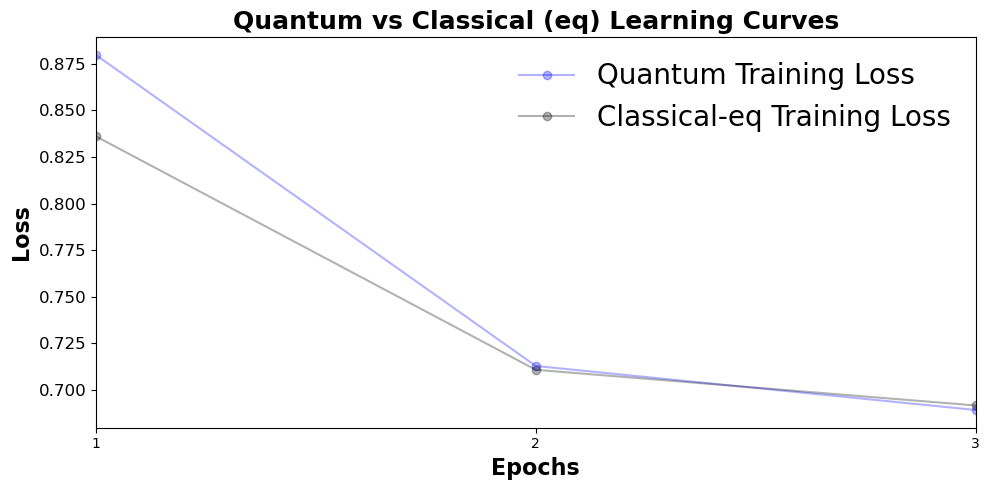

In [15]:
from quantum_transformer_src.analysis import generate_plots_from_checkpoint

generate_plots_from_checkpoint(
    quantum_checkpoint_path="./checkpoints/quantum_example/model_epoch_3.pt",
    classical_equal_param_checkpoint_path="./checkpoints/classical_example/model_epoch_3.pt",
    title="Quantum vs Classical (eq) Learning Curves",
    plot_train_losses=True,
    show_plot=True,
)

As long as a `csv` file contains a header for `SMILES` or `smiles`, other chemical datasets should be able to be trained with this model. Note the tokenization rules utilized here may not be ideal for all chemistry datasets, and can be changed from within the `Transformer_Dataset` class if necessary.

#### Generating Molecules

We can call the `generate_smiles` function to perform inference on our trained model. 
The output is the validity, uniqueness, and novelty percentages for the generated sequences. Valid sequences are those where the resulting string can be successfully parsed by `RDKit`. Novel SMILES strings are those which do not appear in the training set.


This function has arguments: 
- checkpoint_path (str): Path to the model checkpoint.
- save_path (Optional[str]): Path to save the generated SMILES strings.
- choose_best_val_epoch (bool): Choose the best validation epoch for evaluation from any previous epoch.
- num_of_model_queries (int): Number of attempts to generate SMILES strings.
- sampling_batch_size (int): Batch size for sampling.
- MW (Union[float, np.float64]): Molecular weight for conditional sampling.
- HBA (Union[float, np.float64]): Hydrogen bond acceptors for conditional sampling.
- HBD (Union[float, np.float64]): Hydrogen bond donors for conditional sampling.
- nRot (Union[float, np.float64]): Number of rotatable bonds for conditional sampling.
- nRing (Union[float, np.float64]): Number of rings for conditional sampling.
- nHet (Union[float, np.float64]): Number of heteroatoms for conditional sampling.
- TPSA (Union[float, np.float64]): Topological polar surface area for conditional sampling.
- LogP (Union[float, np.float64]): LogP for conditional sampling.
- StereoCenters (Union[float, np.float64]): Number of stereocenters for conditional sampling.
- imputation_method (str): Imputation method for missing physicochemical properties.
- imputation_dataset_path (str): Path to the imputation dataset. Default will be set to the training 
- dataset specified by the train_id from the checkpoint.
- dataset_novelty_check_path (str): Path to the dataset for novelty check. Default will be set to the
- training dataset specified by the train_id from the checkpoint.
- device (str): Device for training, either 'cpu' or 'gpu'.
- qpu_count (int): Number of GPUs to use (-1 = all available GPUs).

In [16]:
from quantum_transformer_src.analysis import generate_smiles

valid, unique, novel = generate_smiles(
    checkpoint_path="./checkpoints/classical_example/model_epoch_3.pt",
    save_dir="./generated_molecules/classical_example.csv",
    choose_best_val_epoch=True,
    num_of_model_queries=1000,
    sampling_batch_size=250,
    device="gpu",
)


print(f"Valid: {valid:.2f}%")
print(f"Unique: {unique:.2f}%")
print(f"Novel: {novel:.2f}%")

2025-02-09 05:06:35,283 [INFO] Quantum target set to: nvidia with QPU count: 4
2025-02-09 05:06:45,013 [INFO] Generating SMILES using model_epoch_3.pt with val_loss 0.66858810627902
Sampling molecules: 100%|██████████| 1000/1000 [00:01<00:00, 995.66it/s] 
2025-02-09 05:06:46,069 [INFO] 588 valid molecules generated (58.80 % of sampled molecules).
2025-02-09 05:06:46,071 [INFO] 585 unique molecules generated (99.49 % of valid molecules)
2025-02-09 05:06:47,214 [INFO] 293 novel molecules generated (50.09 % of unique molecules)


Valid: 58.80%
Unique: 99.49%
Novel: 50.09%


If a model was trained with molecular property embeddings, the `generate_smiles` function allows it to be sampled from conditionally and grants us the option to specify molecular properties. 

A model that is trained with property embeddings will always expect to be fed a complete property vector. Thus, for properties we do not specify, they are [imputed](https://scikit-learn.org/stable/modules/impute.html) from other values in - by default - the training data. By default, unspecified values are imputed with `knn` ([K-Nearest Neighbors](https://scikit-learn.org/stable/modules/impute.html#nearest-neighbors-imputation)), but the `imputation_method` argument can also be `mean`, `median`, `most_frequent`, or `multivariate`.

Below is an example of two sampling experiments where molecules are sampled to have a target weight of 120 and 80, respectively.

In [17]:
import pandas as pd

generate_smiles(
    checkpoint_path="./checkpoints/classical_example_conditions/model_epoch_3.pt",
    save_dir="./generated_molecules/classical_example_conditions_MW_120.csv",
    num_of_model_queries=1000,
    sampling_batch_size=250,
    device="gpu",
    MW=120,
)

MW_120_target = pd.read_csv(
    "./generated_molecules/classical_example_conditions_MW_120.csv"
)["MW"].mean()

generate_smiles(
    checkpoint_path="./checkpoints/classical_example_conditions/model_epoch_3.pt",
    save_dir="./generated_molecules/classical_example_conditions_MW_80.csv",
    num_of_model_queries=1000,
    sampling_batch_size=250,
    device="gpu",
    MW=80,
)

MW_80_target = pd.read_csv(
    "./generated_molecules/classical_example_conditions_MW_80.csv"
)["MW"].mean()

print(" ")
print(f"Average molecular weight for molecules with MW=120: {MW_120_target:.2f}")
print(f"Average molecular weight for molecules with MW=80: {MW_80_target:.2f}")

2025-02-09 05:06:57,289 [INFO] Quantum target set to: nvidia with QPU count: 4
2025-02-09 05:07:07,006 [INFO] Generating SMILES using model_epoch_3.pt with val_loss 0.4918970763683319
2025-02-09 05:07:07,164 [INFO] Imputing missing properties using the 'knn' method.
Sampling molecules: 100%|██████████| 1000/1000 [00:00<00:00, 1545.67it/s]
2025-02-09 05:07:07,846 [INFO] 484 valid molecules generated (48.40 % of sampled molecules).
2025-02-09 05:07:07,847 [INFO] 376 unique molecules generated (77.69 % of valid molecules)
2025-02-09 05:07:08,663 [INFO] 190 novel molecules generated (50.53 % of unique molecules)
2025-02-09 05:07:08,697 [INFO] Quantum target set to: nvidia with QPU count: 4
2025-02-09 05:07:18,395 [INFO] Generating SMILES using model_epoch_3.pt with val_loss 0.4918970763683319
2025-02-09 05:07:18,564 [INFO] Imputing missing properties using the 'knn' method.
Sampling molecules: 100%|██████████| 1000/1000 [00:00<00:00, 1814.11it/s]
2025-02-09 05:07:19,151 [INFO] 442 valid mo

 
Average molecular weight for molecules with MW=120: 114.95
Average molecular weight for molecules with MW=80: 78.54


 
Average molecular weight for molecules with MW=120: 125.65
Average molecular weight for molecules with MW=80: 88.82


#### Attention Maps

To visualize the attention map of a SMILES string, we can use the `get_attention_maps` function. We provide the function with the trained checkpoint file, the directory where the figures will be saved to, and the list of SMILES string to generate an attention map with.

2025-02-09 05:07:25,521 [INFO] Quantum target set to: nvidia with QPU count: 4
2025-02-09 05:07:35,243 [INFO] Using model_epoch_3.pt with val_loss 0.66858810627902


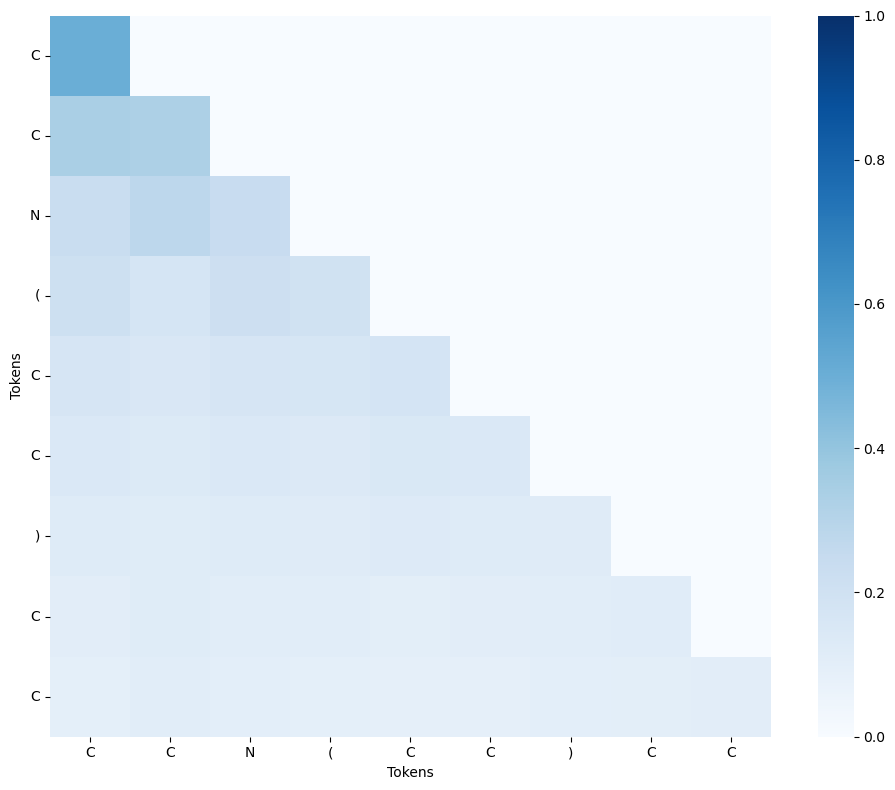

2025-02-09 05:07:35,881 [INFO] Saved attention map for CCN(CC)CC at ./attention_maps/classical_example/CCN(CC)CC_attention.png


2025-02-06 14:54:32,856 [INFO] Saved attention map for CCN(CC)CC at ./attention_maps/classical_example/CCN(CC)CC_attention.png


In [18]:
from quantum_transformer_src.analysis import get_attention_maps

get_attention_maps(
    checkpoint_path="./checkpoints/classical_example/model_epoch_3.pt",
    save_dir="./attention_maps/classical_example/",
    smiles_list=["CCN(CC)CC"],
    choose_best_val_epoch=True,
    show_plots=True,
    device="gpu",
    qpu_count=-1,
)